# **Activity Detection VAE**

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import gc
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE


## ii. General setup

In [4]:
# Directories
basedir = os.getcwd()
datadir = os.path.join(basedir, 'data')

# Training hyperparameters
N_ROUNDS = 15
N_CENTRES = 4
N_EPOCHS = 20
N_FEATURES = 561
BATCH_SIZE = 128
LATENT_DIM = 100

# GPU settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    gc.collect()
    torch.cuda.empty_cache()

# Function to make string bold
def bold(string):
    """ Make string bold."""
    
    return '\033[1m' + string + '\033[0m'


## **1. Load data**

In [5]:
# Custom class to create pytorch Dataset of activity data
class ActivityDataset(Dataset):
    """ Custom PyTorch Dataset 
        of activity data.
    """

    def __init__(self, data_array):
        """
        Arguments:
            data_array (array): NumPy array of data.
        """
        self.data_array = data_array

    def __len__(self):
        return len(self.data_array)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = self.data_array[idx]
        label = sample[-1]
        subject = sample[-2]
        sample = sample[:-2]
        sample = torch.Tensor(sample)

        return sample, label, subject

In [6]:
# Load training and test data
train_file = 'train.csv'
test_file = 'test.csv'
train_data = pd.read_csv(os.path.join(datadir, train_file))
test_data = pd.read_csv(os.path.join(datadir, test_file))

# Replace activities with numeric mapping
labels = train_data['Activity'].unique().tolist()
mapping = dict(zip(labels, range(len(labels))))
inv_mapping = {v: k for k, v in mapping.items()}
train_data.replace({'Activity': mapping}, inplace=True)
test_data.replace({'Activity': mapping}, inplace=True)

# Normalise data
train_temp_columns = train_data.iloc[:, -2:]
test_temp_columns = test_data.iloc[:, -2:]
train_data_norm = train_data.iloc[:, :-2]
test_data_norm = test_data.iloc[:, :-2]
train_data_norm = (train_data_norm-train_data_norm.mean())/train_data_norm.std()
test_data_norm = (test_data_norm-test_data_norm.mean())/test_data_norm.std()
train_data_norm = pd.concat([train_data_norm, train_temp_columns], axis=1)
test_data_norm = pd.concat([test_data_norm, test_temp_columns], axis=1)

# Check feature number is correct
assert train_data.shape[1]-2 == N_FEATURES,\
       f'Training data has incorrect number of features ({train_data.shape[1]-2})! Should be {N_FEATURES}.'
assert test_data.shape[1]-2 == N_FEATURES,\
       f'Test data has incorrect number of features ({test_data.shape[1]-2})! Should be {N_FEATURES}.'

# Print some statistics
print(f'Training data points: {train_data_norm.shape[0]}')
print(f'Test data points: {test_data_norm.shape[0]}')
print(f'Feature number: {N_FEATURES}')

# Create Datasets
train_dataset = ActivityDataset(train_data_norm.to_numpy())
test_dataset = ActivityDataset(test_data_norm.to_numpy())

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, num_workers=0)

Training data points: 7352
Test data points: 2947
Feature number: 561


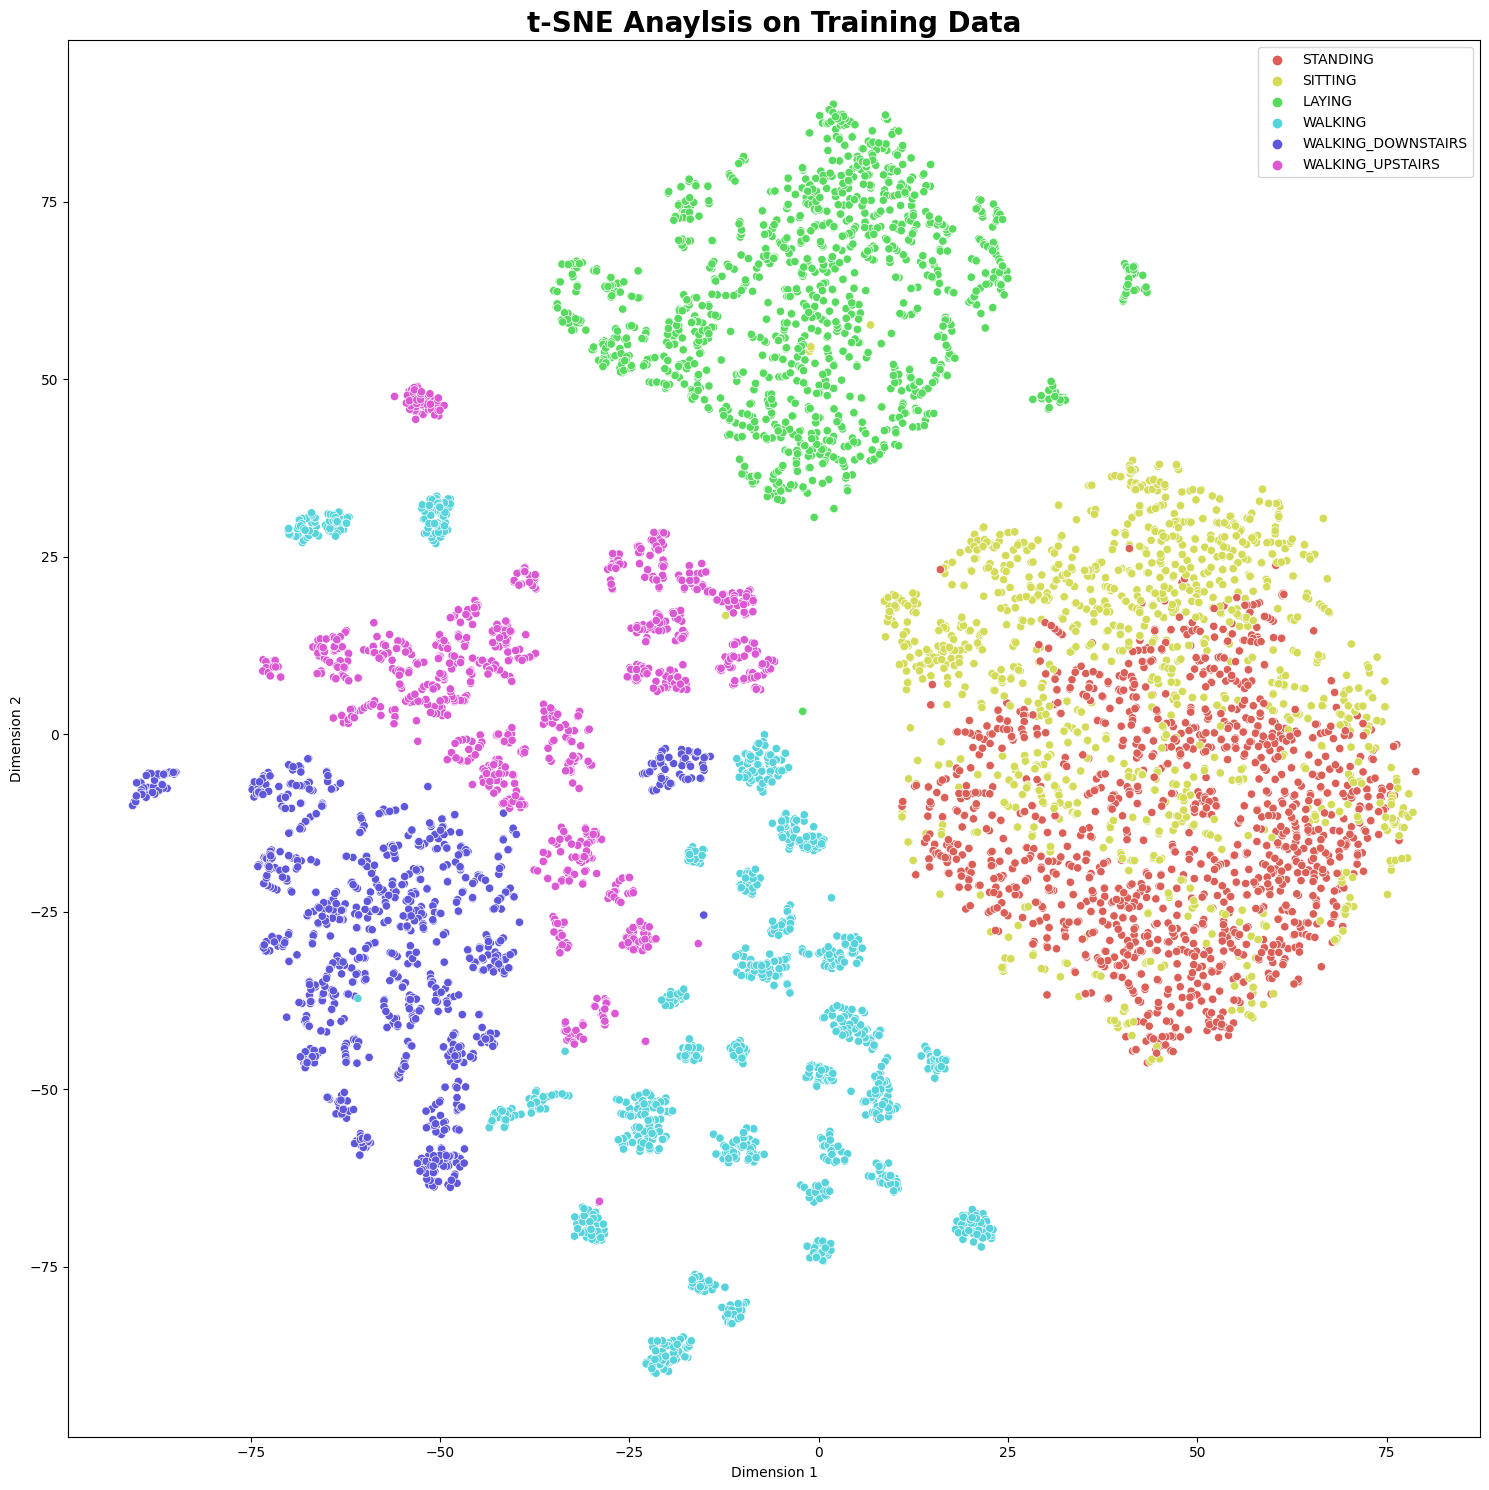

In [8]:
tsne = TSNE(n_components=2, verbose=0, random_state=123)
z = tsne.fit_transform(train_data.to_numpy()[:,:-2])
df = pd.DataFrame()
df["y"] = train_data.replace({'Activity': inv_mapping}).to_numpy()[:,-1]
df["Dimension 1"] = z[:,0]
df["Dimension 2"] = z[:,1]
plt.figure(1, figsize=(15,15))
sns.scatterplot(x="Dimension 1", y="Dimension 2", hue=df.y.tolist(),
                palette=sns.color_palette("hls", 6),
                data=df)
plt.title('t-SNE Anaylsis on Training Data',
          fontweight='bold',
          fontsize=20)
plt.tight_layout()
plt.show()

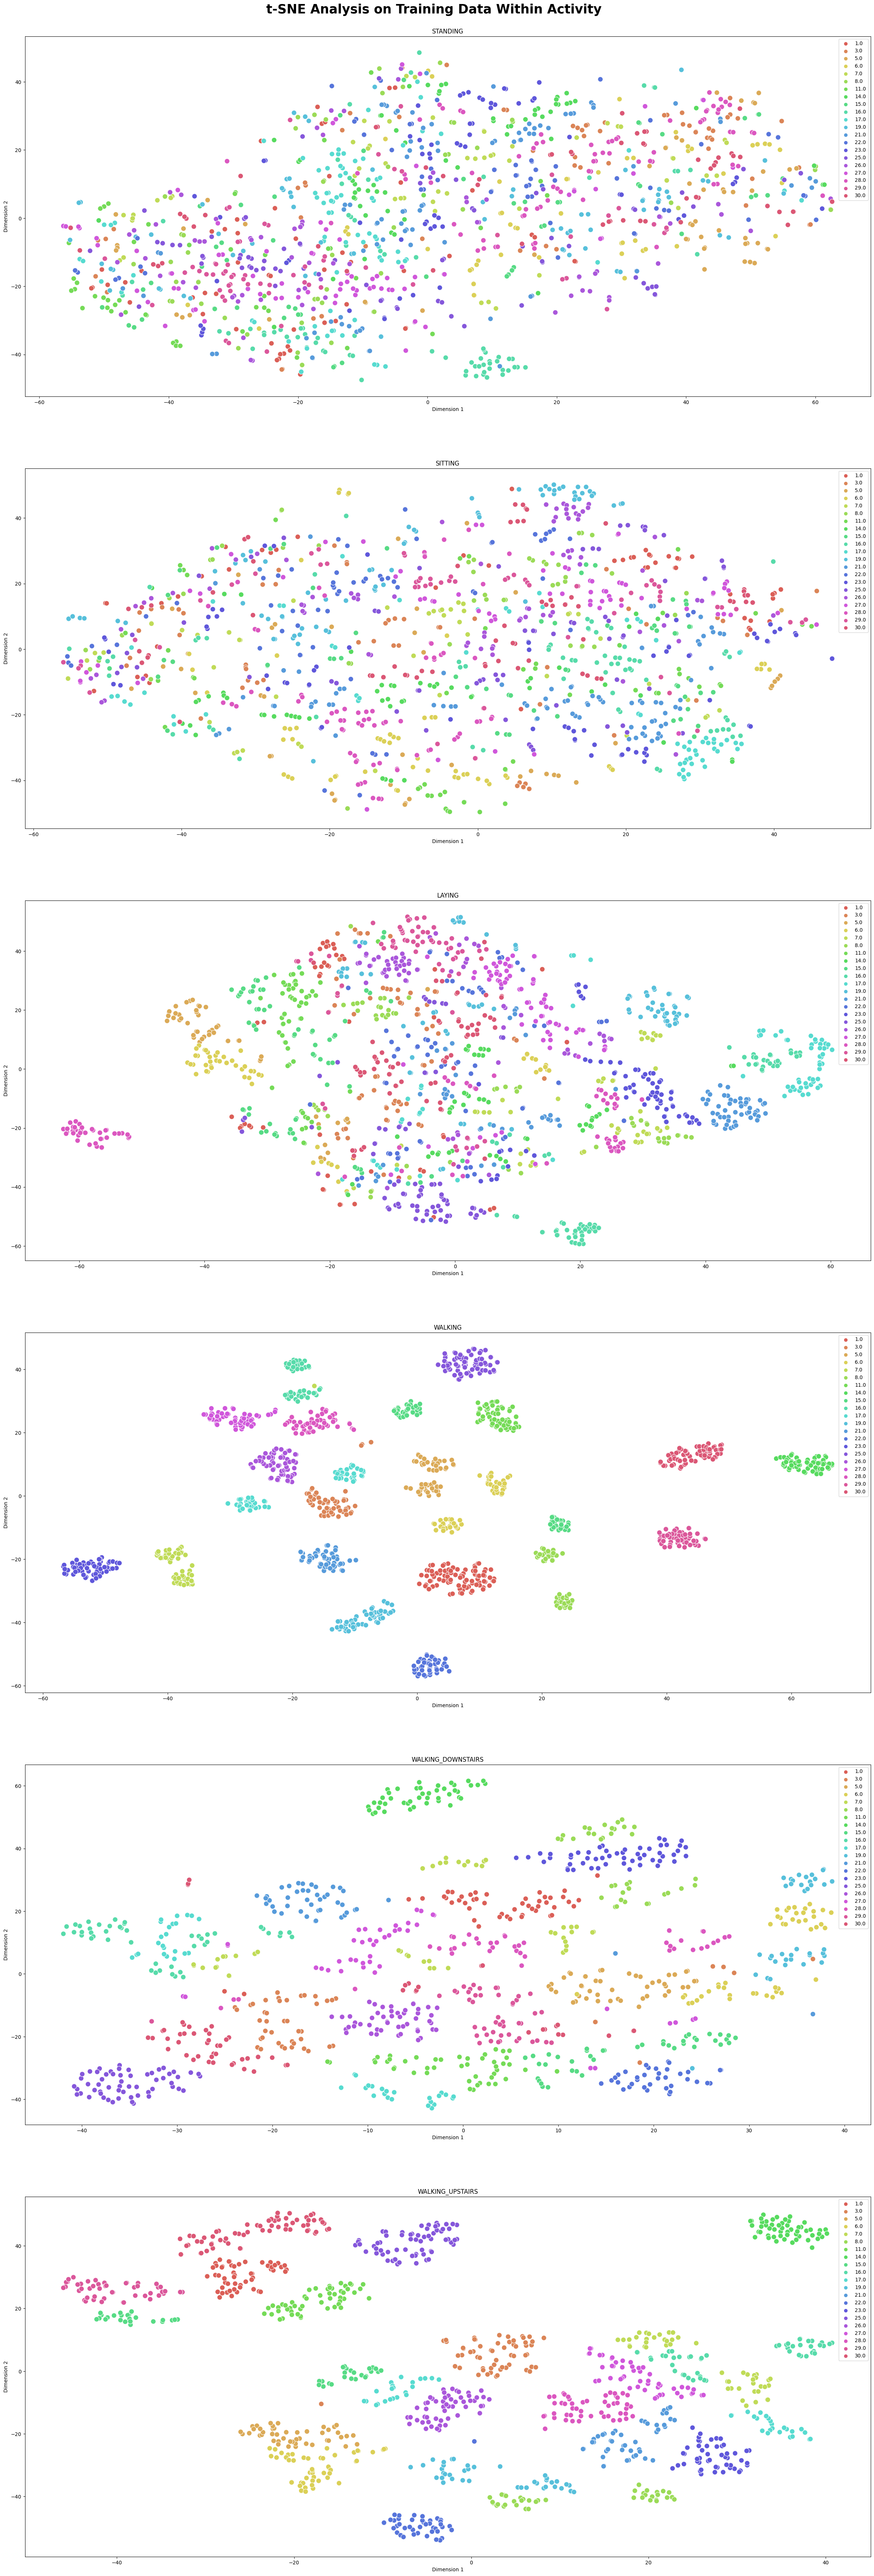

In [9]:
# Split by activity
fig, axs = plt.subplots(6, figsize=(30, 90))
plt.suptitle('t-SNE Analysis on Training Data Within Activity',
             fontweight='bold', fontsize=25,
             y=0.89)
for i, activity in enumerate(inv_mapping):
    train_data_act = train_data[train_data['Activity'] == activity]
    tsne = TSNE(n_components=2, verbose=0, random_state=123)
    z = tsne.fit_transform(train_data_act.to_numpy()[:, :-2])
    df = pd.DataFrame()
    df['subject'] = train_data_act.to_numpy()[:,-2]
    df["Dimension 1"] = z[:,0]
    df["Dimension 2"] = z[:,1]
    sns.scatterplot(x="Dimension 1", y="Dimension 2", s=100,
                    data=df, hue=df.subject.tolist(),
                    palette=sns.color_palette("hls", len(df.subject.unique())),
                    ax=axs[i]).set(title=inv_mapping[activity])
plt.show()

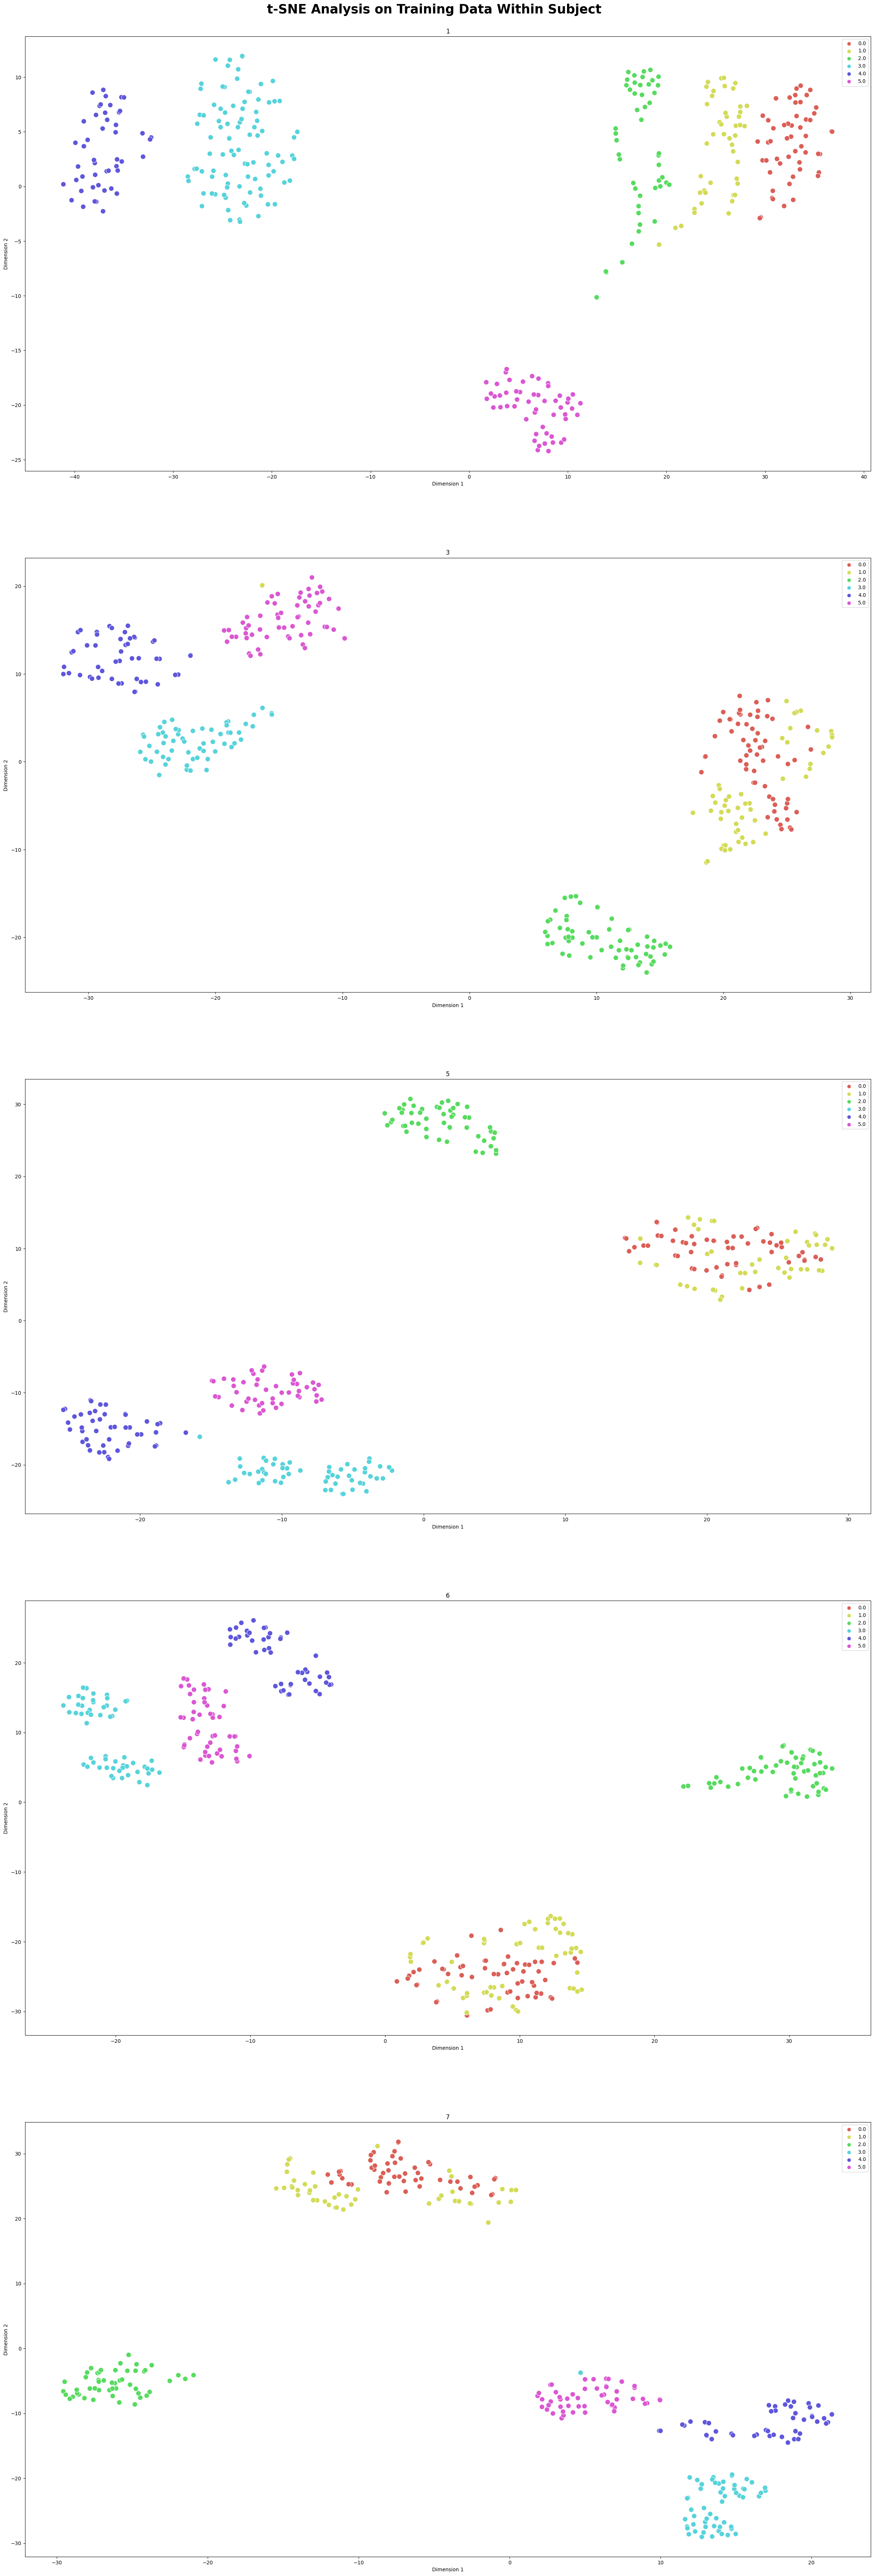

In [10]:
# Split by subjects (not all)
fig, axs = plt.subplots(5, figsize=(30, 90))
plt.suptitle('t-SNE Analysis on Training Data Within Subject',
             fontweight='bold', fontsize=25,
             y=0.89)
for i, subject in enumerate(train_data['subject'].unique()[:5]):
    train_data_sub = train_data[train_data['subject'] == subject]
    tsne = TSNE(n_components=2, verbose=0, random_state=123)
    z = tsne.fit_transform(train_data_sub.to_numpy()[:, :-2])
    df = pd.DataFrame()
    df['activity'] = train_data_sub.to_numpy()[:,-1]
    df["Dimension 1"] = z[:,0]
    df["Dimension 2"] = z[:,1]
    sns.scatterplot(x="Dimension 1", y="Dimension 2",
                    data=df, hue=df.activity.tolist(), s=100,
                    palette=sns.color_palette("hls", len(df.activity.unique())),
                    ax=axs[i]).set(title=subject)
plt.show()

## **2. Define VAE model**

In [11]:
class VAE(nn.Module):
    """ Fully connected VAE model."""
    def __init__(self):
        pass
      
    def encode(self, x):
        """ Encode input to mean and logvar."""
        result = self.encoder(x)
        mu = self.fc_mu(result)
        logvar = self.fc_var(result)

        return [mu, logvar]
    
    def reparameterise(self, mu, logvar):
        """ Reparameterise to sample."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        
        return eps * std + mu

    def decode(self, z):
        """ Decode latent sampling to output."""
        result = self.decoder(z)

        return result
    

    def forward(self, x):
        """ Forward pass of the network."""
        # Check input matches in_features
        if x.shape[-1] != self.in_features:
            raise Exception(f'Input features must be equal to {self.in_features}!')
        
        # Encode input to mean and logvar
        mu, logvar = self.encode(x)

        # Reparameterise
        z = self.reparameterise(mu, logvar)

        # Decode
        return [self.decode(z), z, mu, logvar]

In [12]:
class FCVAE(VAE):
    """ Fully connected VAE model."""
    def __init__(self,
                 in_features,
                 latent_dim):
        super(VAE, self).__init__()

        # Assign variables
        self.in_features = in_features
        self.latent_dim = latent_dim

        # Build Encoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Linear(self.in_features, self.in_features // 2),
                nn.LeakyReLU()
                )
        )
        self.encoder = nn.Sequential(*modules)

        # Linear layers defining distribution parameters
        self.fc_mu = nn.Linear(self.in_features // 2, self.latent_dim)
        self.fc_var = nn.Linear(self.in_features // 2, self.latent_dim)

        # Build Decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Linear(self.latent_dim, self.in_features //2),
                nn.LeakyReLU(),
                nn.Linear(self.in_features //2, self.in_features),
                nn.Sigmoid()
                )
        )
        self.decoder = nn.Sequential(*modules)

In [13]:
class ConvVAE(VAE):
    """ Convolutional VAE model."""
    def __init__(self,
                 in_features,
                 in_channels,
                 latent_dim,
                 feature_dim):
        super(VAE, self).__init__()

        # Assign variables
        self.in_features = in_features
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.feature_dim = feature_dim
        self.total_feature_dim = 32 * self.feature_dim

       # Build Encoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Conv1d(self.in_channels, 16, kernel_size=3),
                nn.BatchNorm1d(16),
                nn.LeakyReLU(),
                nn.Conv1d(16, 32, kernel_size=3),
                nn.BatchNorm1d(32),
                nn.LeakyReLU(),
                nn.Flatten(),
                nn.Linear(self.total_feature_dim, self.total_feature_dim // 2),
                nn.LeakyReLU())
        )
        self.encoder = nn.Sequential(*modules)

        # Linear layers defining distribution parameters
        self.fc_mu = nn.Linear(self.total_feature_dim // 2, self.latent_dim)
        self.fc_var = nn.Linear(self.total_feature_dim // 2, self.latent_dim)

        # Build Decoder
        modules = []
        modules.append(
            nn.Sequential(
                nn.Linear(self.latent_dim, self.total_feature_dim // 2),
                nn.LeakyReLU(),
                nn.Linear(self.total_feature_dim // 2, self.total_feature_dim),
                nn.LeakyReLU(),
                nn.Unflatten(1, (32, self.feature_dim)),
                nn.ConvTranspose1d(32, 16, kernel_size=3),
                nn.BatchNorm1d(16),
                nn.LeakyReLU(),
                nn.ConvTranspose1d(16, self.in_channels, kernel_size=3),
                nn.BatchNorm1d(self.in_channels),
                nn.Sigmoid()
                )
        )
        self.decoder = nn.Sequential(*modules)

In [14]:
# Loss function
class VAELoss(nn.Module):
    """ Loss function for VAE
        using BCE loss and KL 
        divergence.
    """
    def __init__(self):
        super(VAELoss, self).__init__()
        self.criterion = F.mse_loss

    def forward(self, outputs, inputs, mu, logvar, Beta=5):   
        recon_loss = self.criterion(outputs, inputs)
        kl = 0.5 * torch.sum(-1 - logvar + mu.pow(2) + logvar.exp())

        return recon_loss, kl, recon_loss + kl

## **2. Train Fully Connected VAE**

In [15]:
# Initiliase convolutional model
ConnectedVAE = FCVAE(in_features=N_FEATURES, latent_dim=LATENT_DIM).to(device)
params = sum(p.numel() for p in ConnectedVAE.parameters() if p.requires_grad)
print("Total number of parameters for the Connected VAE: {}\n".format(params))
print("Connected VAE architecture:")
print(ConnectedVAE)

# Optimiser and loss
optimizer = torch.optim.Adam(ConnectedVAE.parameters(), lr=1e-3)
criterion = VAELoss()

Total number of parameters for the Connected VAE: 399481

Connected VAE architecture:
FCVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=561, out_features=280, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=280, out_features=100, bias=True)
  (fc_var): Linear(in_features=280, out_features=100, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=280, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_features=280, out_features=561, bias=True)
      (3): Sigmoid()
    )
  )
)


In [16]:
# Initialise loss dictionary
losses = {'Reconstruction': [],
          'KL': [],
          'Training': []
          }

# Begin training
print('Beginning Connected VAE training...\n')
ConnectedVAE.train()

# Loop over epochs
for epoch in range(N_EPOCHS):
    # Running loss containers
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_train_loss = 0.0

    # Loop over batches
    with tqdm(train_dataloader, unit="batch") as tepoch: 
        for batch_idx, (data, label, subject) in enumerate(tepoch):

          # Batch tensor and add channel dimension
          batch_tensor = data.to(device)
          batch_tensor = batch_tensor[:, None, :]

          # Compute reconstructions
          results, z, mu, logvar = ConnectedVAE(batch_tensor)

          # Loss
          recon_loss, kl_loss, train_loss = criterion(results, batch_tensor,
                                                      mu=mu, logvar=logvar)

          # Backpropagation based on the loss
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()

          # Update loss
          running_recon_loss += recon_loss.item()
          running_kl_loss += kl_loss.item()
          running_train_loss += train_loss.item()

          # Log
          if batch_idx % 20 == 0:
            tepoch.set_description(f"Epoch {epoch+1}")
            tepoch.set_postfix(loss=train_loss.item())

        # Average epoch loss
        losses['Reconstruction'].append(running_recon_loss/batch_idx+1)
        losses['KL'].append(running_kl_loss/batch_idx+1)
        losses['Training'].append(running_train_loss/batch_idx+1)

Beginning Connected VAE training...



  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

## **3. Train Convolutional VAE**

In [17]:
# Initiliase convolutional model
ConvolutionalVAE = ConvVAE(in_features=N_FEATURES, in_channels=1,
                           latent_dim=LATENT_DIM, feature_dim=557).to(device)
params = sum(p.numel() for p in ConvolutionalVAE.parameters() if p.requires_grad)
print("Total number of parameters for the Convolutional VAE: {}\n".format(params))
print("Convolutional VAE architecture:")
print(ConvolutionalVAE)

# Optimiser and loss
optimizer = torch.optim.Adam(ConvolutionalVAE.parameters(), lr=1e-5)
criterion = VAELoss()

Total number of parameters for the Convolutional VAE: 320407787

Convolutional VAE architecture:
ConvVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Conv1d(16, 32, kernel_size=(3,), stride=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Flatten(start_dim=1, end_dim=-1)
      (7): Linear(in_features=17824, out_features=8912, bias=True)
      (8): LeakyReLU(negative_slope=0.01)
    )
  )
  (fc_mu): Linear(in_features=8912, out_features=100, bias=True)
  (fc_var): Linear(in_features=8912, out_features=100, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=100, out_features=8912, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Linear(in_f

In [18]:
# Initialise loss dictionary
losses = {'Reconstruction': [],
          'KL': [],
          'Training': []
          }

# Begin training
print('Beginning Convolutional VAE training...\n')
ConvolutionalVAE.train()

# Loop over epochs
for epoch in range(N_EPOCHS):
    # Running loss containers
    running_recon_loss = 0.0
    running_kl_loss = 0.0
    running_train_loss = 0.0

    # Loop over batches
    with tqdm(train_dataloader, unit="batch") as tepoch: 
        for batch_idx, (data, label, subject) in enumerate(tepoch):

          # Batch tensor and add channel dimension
          batch_tensor = data.to(device)
          batch_tensor = batch_tensor[:, None, :]

          # Compute reconstructions
          results, z, mu, logvar = ConvolutionalVAE(batch_tensor)

          # Loss
          recon_loss, kl_loss, train_loss = criterion(results, batch_tensor,
                                                      mu=mu, logvar=logvar)

          # Backpropagation based on the loss
          optimizer.zero_grad()
          train_loss.backward()
          optimizer.step()

          # Update loss
          running_recon_loss += recon_loss.item()
          running_kl_loss += kl_loss.item()
          running_train_loss += train_loss.item()

          # Log
          if batch_idx % 1000 == 0:
            tepoch.set_description(f"Epoch {epoch+1}")
            tepoch.set_postfix(loss=train_loss.item())

        # Average epoch loss
        losses['Reconstruction'].append(running_recon_loss/batch_idx+1)
        losses['KL'].append(running_kl_loss/batch_idx+1)
        losses['Training'].append(running_train_loss/batch_idx+1)

Beginning Convolutional VAE training...



  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

  0%|          | 0/58 [00:00<?, ?batch/s]

## **4. Assess Latent Variables**

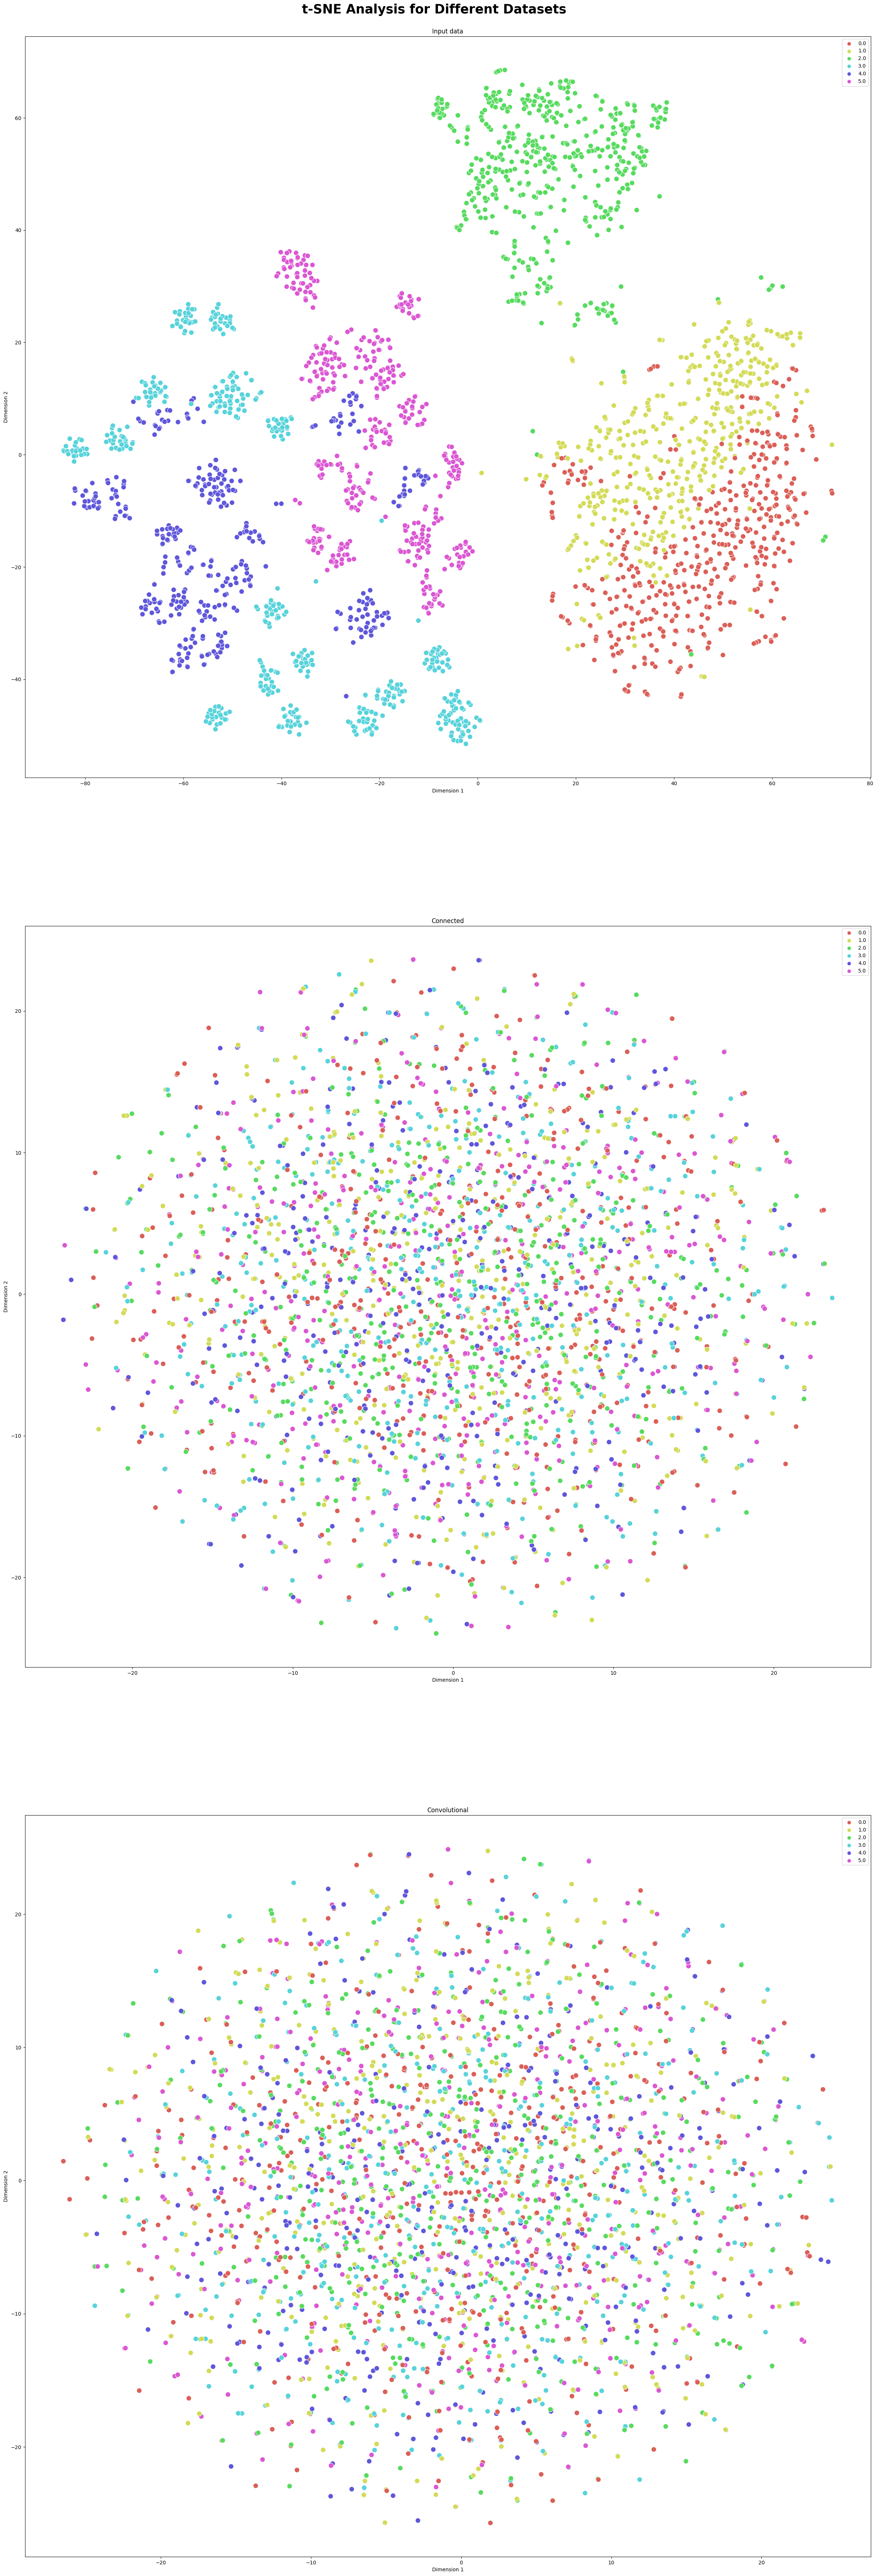

In [19]:
# Containers for test evaluation
connecteds = []
convolutionals = []
data_list = []
labels = []

# Run test data through models
ConnectedVAE.eval()
ConvolutionalVAE.eval()
with torch.no_grad():
    for batch_idx, (data, label, subject) in enumerate(test_dataloader):
        data = data.to(device)
        data = data[:, None, :]
        connected_z = ConnectedVAE(data)[1].cpu()
        convolutional_z = ConvolutionalVAE(data)[1].cpu()
        data.cpu()

        # Append to lists
        connecteds.append(connected_z)
        convolutionals.append(convolutional_z)
        labels.append(label)
        data_list.append(data)

# Concatenate tensors
connecteds = torch.cat(connecteds).cpu()
connecteds = connecteds.view(connecteds.shape[0], -1)
convolutionals = torch.cat(convolutionals).cpu()
convolutionals = convolutionals.view(convolutionals.shape[0], -1)
data_list = torch.cat(data_list).cpu()
data_list = data_list.view(data_list.shape[0], -1)
labels = torch.cat(labels).cpu()

# Create TSNE object
tsne = TSNE(n_components=2, verbose=0, random_state=0)

# Plot TSNE
fig, axs = plt.subplots(3, figsize=(30,90))
plt.suptitle('t-SNE Analysis on Test Data',
             fontweight='bold', fontsize=25,
             y=0.89)
for i, (tag, data) in enumerate(zip(['Input data',
                                     'Connected',
                                     'Convolutional'],
                                    [data_list, connecteds, convolutionals])):
    z = tsne.fit_transform(data)
    df = pd.DataFrame()
    df["y"] = labels
    df["Dimension 1"] = z[:,0]
    df["Dimension 2"] = z[:,1]
    sns.scatterplot(x="Dimension 1", y="Dimension 2", s=100,
                    hue=df.y.tolist(),
                    ax=axs[i], palette=sns.color_palette("hls", 6),
                    data=df).set(title=tag)